In [1]:
# importing libraries
import pandas as pd 
import numpy as np
import pickle as pkl
import matplotlib as mpl 
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

import torch
print(f"Pytorch version: {torch.__version__}")
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# setting seed to get reproducible results
torch.manual_seed(0)
np.random.seed(0)

Matplotlib is building the font cache; this may take a moment.


Pytorch version: 1.7.1


In [2]:
# Setting device to GPU if it's available to train the model on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

cuda:0


In [4]:
# RandomForest imputed dataset 
df_rf = pd.read_csv(r"/content/drive/MyDrive/ida_data/forestImputedTrain.csv")
print(df_rf.shape)
df_rf.head()

(80000, 12)


,ID,Expense,Income,Loan type,Occupation type,Age,Score1,Score2,Score3,Score4,Score5,Label
0,1.0,1830.943788,14767.28013,1.0,1.0,1.0,0.016885,205.196182,22.521523,600.911200,3464.613291,0.0
1,2.0,1645.302546,15272.26775,1.0,1.0,0.0,0.240375,194.266317,5.349117,600.888816,3374.921455,0.0
2,3.0,1555.026392,17482.49734,0.0,1.0,0.0,0.213921,183.529871,-1.054954,598.596944,3331.304886,0.0
3,4.0,1681.231479,16257.66493,0.0,1.0,0.0,0.303909,191.228965,6.971750,602.447203,3392.275849,0.0
4,5.0,1777.648916,16316.29914,1.0,0.0,1.0,0.298502,224.074728,11.218489,605.947340,3438.864083,0.0


In [3]:
# we have trained a Generative Adversarial Network on the data to give us synthetic data
# Now we randomly sample rows of minority class from the synthetic data to add it
# and add them to our dataframe to reduce class imbalance
def ctgan_oversample(df_path, ctgan_data_path, target_ratio):
    """Splits the dataset into train and test with a 80:20 ratio and oversamples the
    minority class from the train dataset upto the ratio that we want. It uses samples 
    from GAN generated synthetic data to upsample the minority class

    Args:
        df_path (str): path of original dataframe
        ctgan_data_path (str): path of the GAN generated synthetic data
        target_ratio (float): ratio of majority to minority class after oversampling

    Returns:
        pd.DataFrame: Train and test datasets
    """
    
    df = pd.read_csv(df_path)

    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
 
    ctgan_df = pd.DataFrame(np.load(ctgan_data_path), columns=df_train.columns)

    c_0 = df[df['Label']==0].shape[0]
    c_1 = df[df['Label']==1].shape[0]

    print("Ratio of class 0: class 1 in orginal data is {0:.2f}%:{1:.2f}%".format(c_0/(c_0+c_1)*100, c_1/(c_0+c_1)*100))

    additional_samples = ctgan_df[ctgan_df['Label']==1].sample(n=round(c_0/target_ratio-c_1), random_state=42)

    c_1 += additional_samples.shape[0]
    print("Ratio of class 0: class 1 after resampling is {0:.2f}%:{1:.2f}%".format(c_0/(c_0+c_1)*100, c_1/(c_0+c_1)*100))

    df_non_skewed = pd.concat([df_train, additional_samples], axis=0).sample(frac=1, random_state=69).reset_index(drop=True)

    return df_non_skewed, df_test    

In [4]:
# performs oversampling  + some basic operations necessary to make the data ready
# for model fitting

def final_cleaned(resample_method="gan"):
    """Performs upsampling and labels from input features

    Returns:
        pd.DataFrame: train features, test features, train labels, test labels
    """
    if resample_method == "gan":
        X_train, X_test = ctgan_oversample(df_path=r"cleaned_data\forestImputedTrain.csv",
                            ctgan_data_path=r"cleaned_data\ctgan_8L_data.npy",
                            target_ratio=60/40)

        X_train.drop(columns=['ID'], inplace=True)
        X_test.drop(columns=['ID'], inplace=True)

        categorical_cols = ["Loan type","Occupation type","Age"]
        X_train[categorical_cols] = X_train[categorical_cols].astype(object)
        X_test[categorical_cols] = X_test[categorical_cols].astype(object)

        y_train = X_train.pop("Label")
        y_test = X_test.pop("Label")

        return X_train, X_test, y_train, y_test

    elif resample_method == "smote":

        X_train, X_test = train_test_split(pd.read_csv(r"cleaned_data\forestImputedTrain.csv"),
                                           test_size=0.2)

        X_train.drop(columns=['ID'], inplace=True)
        X_test.drop(columns=['ID'], inplace=True)

        y_train = X_train.pop("Label")
        y_test = X_test.pop("Label")

        categorical_cols = ["Loan type","Occupation type","Age"]
        categorical_index = [i for i in range(len(X_train.columns)) if X_train.columns[i] in categorical_cols]
        
        smote = SMOTENC(sampling_strategy = 40/60, categorical_features=categorical_index)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        X_res = pd.DataFrame(X_res, columns=X_train.columns)
        y_res = pd.DataFrame(y_res)

        X_res[categorical_cols] = X_res[categorical_cols].astype(object)
        X_test[categorical_cols] = X_test[categorical_cols].astype(object)

        return X_res, X_test, y_res, y_test

X_train, X_test, y_train, y_test = final_cleaned(resample_method="smote")

In [8]:
X_train.head()

,Expense,Income,Loan type,Occupation type,Age,Score1,Score2,Score3,Score4,Score5
0,1599.684340,17065.52308,0,1,1,0.401602,200.640414,-1.120416,603.539753,3352.881198
1,1729.609325,16625.35468,0,1,0,0.173100,194.539602,7.094905,599.891263,3415.653944
2,1722.839176,13959.94843,0,2,0,0.270238,151.637609,5.029984,597.358924,3412.382973
3,1729.332883,14285.65472,0,2,0,0.192543,167.729187,5.650340,597.252220,3415.520382
4,1899.888807,14549.96714,0,1,0,-0.011830,177.591179,26.780329,598.909797,3497.925996


DATA LOADING 

In [9]:
## hyperparameters for the model##
INPUT_SIZE=10 # input features dimensions
BATCH_SIZE=32 
lr = 0.001 # learning rate for optimizer
EPOCHS = 23

In [6]:
## Setting up dataset class for model ##

class CSVData(Dataset):
    def __init__(self, X, y, train=True, preprocess=True, transform=None):
        """Assign values to variables

        Args:
            X (pd.DataFrame): Input features
            y (pd.DataFrame): labels
            train (bool, optional): if training data or not. Defaults to True.
            preprocess (bool, optional): if preprocessing required or not. Defaults to True.
            transform ([type], optional): sklearn transform to apply to data. Defaults to None.
        """

        self.transform = transform

        if preprocess: # if preprocessing is to be done
            if train: # if its training data

                # we perform scaling for numerical columns
                ct = ColumnTransformer([('scaler', StandardScaler(), make_column_selector(dtype_exclude=object))],
                                       remainder='passthrough')
                X = np.array(ct.fit_transform(X), dtype=np.float32)
                self.transform = ct # save the transform for testing data

            else: # if its testing data (in that case transform will contain train data ColumnTransformer)
                X = np.array(self.transform.transform(X), dtype=np.float32)
            
        # convert the final dataset into pytorch tensors
        self.X = torch.from_numpy(X)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)

    def __len__(self):
        """calculates the total length of the dataset

        Returns:
            int: length of the dataset
        """     
        return len(self.y)

    def __getitem__(self, idx):
        """Returns a sample from the dataset by index

        Args:
            idx (list): list of indices

        Returns:
            torch.tensor: features, labels
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]

In [11]:
# creating pytorch datasets for train and test #
train_ds = CSVData(X_train,y_train, train=True, preprocess=True, transform=None)
test_ds = CSVData(X_test, y_test, train=False, preprocess=True, transform=train_ds.transform)

In [12]:
# creating dataloader objects to batch data and feed it into the model #
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE)

BUILDING THE MODEL

In [7]:
# defining the model architecture #
class FraudModel(nn.Module):
    def __init__(self):
        super(FraudModel,self).__init__()

        self.fc1 = nn.Linear(INPUT_SIZE, 32)
        self.fc2 = nn.Linear(32,100)
        self.fc3 = nn.Linear(100,150)
        self.fc4 = nn.Linear(150,100)
        self.fc5 = nn.Linear(100,50)
        self.fc6 = nn.Linear(50,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        return torch.sigmoid(self.fc6(x))

In [14]:
# create an instance of our model
model = FraudModel()
model.to(device) # transfers operations to GPU (in our case)

# setting up the optimizer and the loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Binary Crossentropy Loss for Binary classification
criterion = nn.BCELoss()

In [11]:
# creating a custom function for accuracy 
def accuracy(y_true,y_prob):
    y_pred = (y_prob>0.5).float()
    
    acc = (y_pred == y_true).sum().item()
    return acc/y_true.shape[0]

# converts probability returned by a neural network to labels
def to_labels(y_prob):
    return (y_prob>0.5).float()

In [16]:
## Training and validating the model ##

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    training_stats = []
    template = "Epoch {} Training loss: {} Test Loss: {} Test Accuracy: {}"

    for epoch in range(1, epochs+1):

        # training loop#
        model.train()
        total_train_loss = 0

        for i, (features, labels) in enumerate(train_loader):

            features, labels = features.to(device), labels.to(device).view(-1,1)
            
            # wiping off existing gradients
            model.zero_grad()
            optimizer.zero_grad()

            # predicting and calculating loss function
            predictions = model(features)
            loss = criterion(predictions, labels)
            total_train_loss += loss.item() 

            # backpropagate and update the weights
            loss.backward()
            optimizer.step()
        
        # average loss for the epoch
        avg_train_loss = total_train_loss/len(train_loader)

        # validation loop#
        model.eval()
        total_test_loss = 0
        total_test_acc =0

        for i, (t_features, t_labels) in enumerate(test_loader):

            t_features, t_labels = t_features.to(device), t_labels.to(device).view(-1,1)

            # no backpropagation
            with torch.no_grad():
                
                # testing the model and calculating loss
                t_predictions = model(t_features)
                t_loss = criterion(t_predictions, t_labels)


            total_test_loss += t_loss.item()
            total_test_acc += accuracy(t_labels, t_predictions)

        # average loss and accuracy per epoch
        avg_test_loss = total_test_loss/len(test_loader)
        avg_test_acc = total_test_acc/len(test_loader)
        
        print(template.format(epoch, avg_train_loss, avg_test_loss, avg_test_acc))

        # saving the training statistics
        training_stats.append({
            "epoch": epoch,
            "training_loss": avg_train_loss,
            "test_loss": avg_test_loss,
            "test_accuracy": avg_test_acc

        })

    return training_stats

In [17]:
# We obtain the learning curve from the model to visualize it 
training_stats = train_model(model, train_loader, test_loader, criterion, optimizer, EPOCHS)

Epoch 1 Training loss: 0.12310452694637644 Test Loss: 0.06359963733609766 Test Accuracy: 0.9818125
Epoch 2 Training loss: 0.07443431537638734 Test Loss: 0.05972847055457532 Test Accuracy: 0.9843125
Epoch 3 Training loss: 0.0638077438334347 Test Loss: 0.040677541759330776 Test Accuracy: 0.9909375
Epoch 4 Training loss: 0.05860811255514969 Test Loss: 0.0592120268503204 Test Accuracy: 0.98225
Epoch 5 Training loss: 0.05651769333404682 Test Loss: 0.05929796186089516 Test Accuracy: 0.983125
Epoch 6 Training loss: 0.05382352590696949 Test Loss: 0.04115504117729142 Test Accuracy: 0.989125
Epoch 7 Training loss: 0.05264933697530255 Test Loss: 0.0600165194766596 Test Accuracy: 0.9841875
Epoch 8 Training loss: 0.05114637133011364 Test Loss: 0.06674867695197463 Test Accuracy: 0.9815625
Epoch 9 Training loss: 0.05036213908316104 Test Loss: 0.07445186608005315 Test Accuracy: 0.9761875
Epoch 10 Training loss: 0.04900642605350812 Test Loss: 0.05094794245623052 Test Accuracy: 0.986625
Epoch 11 Trainin

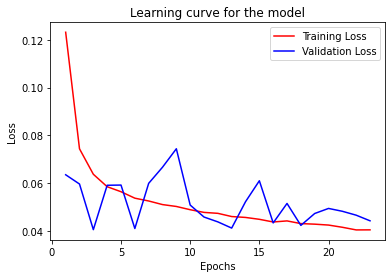

In [18]:
# Plotting the training and validation losses with epochs 
# This is called the model's learning curve
epochs = [x['epoch'] for x in training_stats]
training_loss = [x['training_loss'] for x in training_stats]
testing_loss = [x['test_loss'] for x in training_stats]

fig, ax = plt.subplots()
ax.set_title("Learning curve for the model")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.plot(epochs, training_loss, c="red", label = "Training Loss")
ax.plot(epochs, testing_loss, c ="blue", label="Validation Loss")
plt.legend()

In [19]:
# predict on test data using the model and calculate metrics
y_pred = to_labels(model(test_ds[:][0].to(device))).detach().to('cpu').numpy()
y_test = test_ds[:][1].cpu().numpy()

print(classification_report(y_test, y_pred))
print("F1 score: {}".format(f1_score(y_test, y_pred, average="weighted")))

precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     14955
         1.0       0.91      0.95      0.93      1045

    accuracy                           0.99     16000
   macro avg       0.95      0.97      0.96     16000
weighted avg       0.99      0.99      0.99     16000

F1 score: 0.9901597409360857


In [20]:
## Now we train the model on the complete dataset before giving test outputs
## Re-run cell where model is defined and compiled  before running this cell to create a fresh model

# Preprocessing step
X_train, X_test, y_train, y_test = final_cleaned(resample_method="smote")
X_total = pd.concat([X_train,X_test], axis=0, ignore_index=True)
y_total = pd.concat([y_train,y_test], axis=0, ignore_index=True)

# Data Loading 
full_ds = CSVData(X_total, y_total, train=True, preprocess=True)
full_loader = DataLoader(dataset=full_ds, batch_size=BATCH_SIZE)

# here test dataset is a part of train dataset itself and just acts as a dummy 
test_ds2 = CSVData(X_test, y_test,train=False, transform=full_ds.transform)
test_loader2 = DataLoader(dataset=test_ds2, batch_size=BATCH_SIZE)

# initiate a model to train on the entire data for prediction
full_model = FraudModel()
full_model.to(device)

# select an optimizer and loss 
optimizer2 = torch.optim.Adam(full_model.parameters(), lr=lr)
criterion2 = nn.BCELoss()

_ = train_model(full_model, full_loader, test_loader2, criterion2, optimizer2, EPOCHS)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1 Training loss: 0.0744083132151869 Test Loss: 0.055704201086889955 Test Accuracy: 0.9845625
Epoch 2 Training loss: 0.0801643391642475 Test Loss: 0.05077591909165494 Test Accuracy: 0.9871875
Epoch 3 Training loss: 0.05354492941281143 Test Loss: 0.054174045846797525 Test Accuracy: 0.985875
Epoch 4 Training loss: 0.07426278310550313 Test Loss: 0.04624743463587947 Test Accuracy: 0.9879375
Epoch 5 Training loss: 0.05089039380027951 Test Loss: 0.049202135943807665 Test Accuracy: 0.9871875
Epoch 6 Training loss: 0.07769690306572404 Test Loss: 0.0437684197362978 Test Accuracy: 0.9886875
Epoch 7 Training loss: 0.04654765852936035 Test Loss: 0.04290651250304654 Test Accuracy: 0.9888125
Epoch 8 Training loss: 0.04466243230747717 Test Loss: 0.04587507486715913 Test Accuracy: 0.9883125
Epoch 9 Training loss: 0.04208224283793989 Test Loss: 0.04410460187541321 Test Accuracy: 0.9893125
Epoch 10 Training loss: 0.045971474436796736 Test Loss: 0.04404268177319318 Test Accuracy: 0.989125
Epoch 11 T

In [21]:
## save the model and the transforms ##
torch.save(full_model,"IDAModel.pth")
pkl.dump(full_ds.transform, open("dl_transform.pkl","wb"))

In [9]:
## predicting on the actual test data ##
model_path = r"final_results\IDAModel.pth"
transform_path = r"final_results\dl_transform.pkl"
test_x_path = r"org_data\test_x.csv"

def encode(df):
    for i in range(len(df)):
        cell = df['Loan type'].iloc[i]
        if cell == 'A':
            df['Loan type'].iloc[i] = 0
        elif cell == 'B':
            df['Loan type'].iloc[i] = 1
        
    for i in range(len(df)):
        cell = df['Occupation type'].iloc[i]
        if cell == 'X':
            df['Occupation type'].iloc[i] = 0
        elif cell == 'Y':
            df['Occupation type'].iloc[i] = 1
        elif cell == 'Z':
            df['Occupation type'].iloc[i] = 2


def predict(test_x_path, model_path, transform_path, save_path=None):
    """Predicts model ouput on new data

    Args:
        test_x_path (str): path of new data in .csv format
        model_path (str): path of model stored in .pth format
        transform_path (str): path of the transform stored in .pkl format
        save_path (str, optional): path to save the output .csv file. Defaults to None.

    Returns:
        pd.DataFrame: output labels for new data
    """

    transform = pkl.load(open(transform_path,"rb"))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    model = torch.load(model_path)
    model.to(device)

    # a bit of preprocessing required
    test_x = pd.read_csv(test_x_path)
    encode(test_x)
    test_x.drop(columns="ID_Test", inplace=True)

    categorical_cols = ["Loan type","Occupation type","Age"]
    test_x[categorical_cols] = test_x[categorical_cols].astype(object)

    dummy_y = pd.DataFrame(np.zeros(shape=(len(test_x),1)))

    test_data = CSVData(test_x,dummy_y, train=False, preprocess=True, transform=transform)

    y_pred = to_labels(model(test_data[:][0].to(device))).detach().to('cpu').numpy()
   
    results = pd.DataFrame(y_pred)

    # Uncomment the line below if results are to be saved in a csv file
    results.to_csv(save_path, index=False)

    return results   

In [10]:
results = predict(test_x_path,model_path, transform_path,"results.csv")

In [1]:
### TO GET THE PROBABILITY OF PREDICTIONS 

# y_prob = (model(test_data[:][0].to(device))).detach().to('cpu').numpy()
# probs = pd.DataFrame(y_prob)
# probs.to_csv('DL_prob_predictions', index=False)